# Import libraries and load data

In [20]:
import psycopg2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score, log_loss
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier, plot_importance
from scipy.stats import uniform, randint
from sklearn import tree
from lightgbm import LGBMClassifier

In [2]:

db_params = {
    "host": "localhost",
    "port": "5432",
    "database": "vnstockdw",
    "user": "postgres",
    "password": "postgres"
}

table_name = "stock_history"
table_schema = "public"

conn = psycopg2.connect(**db_params)

cur = conn.cursor()

cur.execute(f"SELECT * FROM {table_name}")

rows = cur.fetchall()

col_names = [desc[0] for desc in cur.description]

stock_df = pd.DataFrame(rows, columns=col_names)

cur.close()
conn.close()

### Data columns

In [3]:
stock_df.columns

Index(['created_at', 'updated_at', 'status', 'symbol', 'open', 'high', 'low',
       'close', 'volume', 'date', 'price_change_to_1_day(s)_ago',
       'price_change_to_2_day(s)_ago', 'price_change_to_3_day(s)_ago',
       'volume_change_to_1_day(s)_ago', 'volume_change_to_2_day(s)_ago',
       'volume_change_to_3_day(s)_ago', 'price_difference',
       'median_volume_3_day(s)_periods', 'std_volume_3_day(s)_periods',
       'median_price_change_3_day(s)_periods',
       'std_price_change_3_day(s)_periods',
       'median_volume_change_3_day(s)_periods',
       'std_volume_change_3_day(s)_periods', 'sma_3_days', 'sma_5_days',
       'wma_3_days', 'wma_5_days', 'ema_3_days', 'ema_5_days',
       'bool_sma_3_days', 'bool_sma_5_days', 'bool_wma_3_days',
       'bool_wma_5_days', 'bool_ema_3_days', 'bool_ema_5_days',
       'macd_of_ema3_and_ema5', '%k_3_days', '%k_5_days', '%d_3_days',
       '%d_5_days', 'rsi_3_days', 'rsi_5_days', 'williams_%r_3_days',
       'ad_3_days', 'cci_3_days', 'b

### Data shape

In [4]:
stock_df.shape

(177796, 60)

# Label Creation

In [5]:
stock_df.date.value_counts()

date
2023-08-18    1111
2023-09-08    1107
2023-08-11    1103
2023-06-23    1102
2023-07-28    1100
              ... 
2024-01-15      63
2024-01-10      63
2024-01-09      63
2024-01-17      62
2024-01-16      62
Name: count, Length: 195, dtype: int64

In [6]:
stock_df.head()

,created_at,updated_at,status,symbol,open,high,low,close,volume,date,...,bool_%d_5_days,bool_cci_3_days,bool_williams_%r_3_days,percentage_change_1_day(s),percentage_change_2_day(s),percentage_change_3_day(s),obv,ft_min_6_days,ft_max_6_days,ft_mean_6_days
0,2024-02-23 16:59:55.145141,2024-02-23 16:59:55.145141,True,ABB,7640.0,7820.0,7640.0,7640.0,430400.0,2023-05-04,...,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-02-23 16:59:55.145141,2024-02-23 16:59:55.145141,True,ABB,7640.0,7730.0,7550.0,7730.0,786100.0,2023-05-05,...,NaN,NaN,1.0,0.011643,NaN,NaN,786100.0,0.500000,0.500000,0.500000
2,2024-02-23 16:59:55.145141,2024-02-23 16:59:55.145141,True,ABB,7550.0,7910.0,7550.0,7820.0,1907900.0,2023-05-08,...,NaN,-1.0,1.0,0.011509,0.023018,0.0,1907900.0,0.333333,0.333333,0.333333
3,2024-02-23 16:59:55.145141,2024-02-23 16:59:55.145141,True,ABB,7820.0,8090.0,7820.0,8000.0,1686400.0,2023-05-09,...,NaN,-1.0,1.0,0.022500,0.033750,0.0,1686400.0,0.250000,0.500000,0.333333
4,2024-02-23 16:59:55.145141,2024-02-23 16:59:55.145141,True,ABB,8000.0,8090.0,7910.0,8000.0,1074000.0,2023-05-10,...,1.0,-1.0,1.0,0.000000,0.022500,0.0,0.0,0.200000,0.400000,0.300000


In [7]:
grouped_df = stock_df.groupby(['date', 'symbol'])
print("Columns with different dates and symbol:", len(grouped_df))

Columns with different dates and symbol: 177796


In [8]:
stock_df['date'] = pd.to_datetime(stock_df['date'])

stock_df['label'] = None

stock_df['future_date'] = stock_df['date'] + pd.DateOffset(days=3)

merged_df = stock_df.merge(stock_df, how='left', left_on=['symbol', 'future_date'], right_on=['symbol', 'date'], suffixes=('', '_future'))

merged_df['price_difference'] = merged_df['close_future'] - merged_df['close']
merged_df['label'] = np.where(merged_df['price_difference'] > 0, 1, 0)

merged_df.loc[merged_df['close_future'].isnull(), 'label'] = None
# merged_df.loc[:, ["symbol", "date", "close", "future_date", "close_future"]]

stock_df['label'] = merged_df['label']

stock_df.drop(['future_date'], axis=1, inplace=True)

stock_df.head()

,created_at,updated_at,status,symbol,open,high,low,close,volume,date,...,bool_cci_3_days,bool_williams_%r_3_days,percentage_change_1_day(s),percentage_change_2_day(s),percentage_change_3_day(s),obv,ft_min_6_days,ft_max_6_days,ft_mean_6_days,label
0,2024-02-23 16:59:55.145141,2024-02-23 16:59:55.145141,True,ABB,7640.0,7820.0,7640.0,7640.0,430400.0,2023-05-04,...,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-02-23 16:59:55.145141,2024-02-23 16:59:55.145141,True,ABB,7640.0,7730.0,7550.0,7730.0,786100.0,2023-05-05,...,NaN,1.0,0.011643,NaN,NaN,786100.0,0.500000,0.500000,0.500000,1.0
2,2024-02-23 16:59:55.145141,2024-02-23 16:59:55.145141,True,ABB,7550.0,7910.0,7550.0,7820.0,1907900.0,2023-05-08,...,-1.0,1.0,0.011509,0.023018,0.0,1907900.0,0.333333,0.333333,0.333333,1.0
3,2024-02-23 16:59:55.145141,2024-02-23 16:59:55.145141,True,ABB,7820.0,8090.0,7820.0,8000.0,1686400.0,2023-05-09,...,-1.0,1.0,0.022500,0.033750,0.0,1686400.0,0.250000,0.500000,0.333333,1.0
4,2024-02-23 16:59:55.145141,2024-02-23 16:59:55.145141,True,ABB,8000.0,8090.0,7910.0,8000.0,1074000.0,2023-05-10,...,-1.0,1.0,0.000000,0.022500,0.0,0.0,0.200000,0.400000,0.300000,NaN


In [ ]:
# stock_df['date'] = pd.to_datetime(stock_df['date'])

# stock_df['label'] = None

# for index, row in stock_df.iterrows():
#     future_rows = stock_df[(stock_df['date'] == row['date'] + pd.DateOffset(days=3)) & (stock_df['symbol'] == row['symbol'])]
#     if not future_rows.empty:
#         future_row = future_rows.iloc[0] 
#         price_difference = future_row['close'] - row['close']
#         if price_difference > 0:
#             stock_df.at[index, 'label'] = 1
#         else:
#             stock_df.at[index, 'label'] = 0

# stock_df.head()

In [ ]:
# stock_df.to_csv('stock_data_transformed.csv', index=False)

In [ ]:
# stock_df = pd.read_csv('stock_data_transformed.csv')

Check transformation integrity

In [9]:
sample_rows = stock_df.sample(5) 

for index, sample_row in sample_rows.iterrows():
    symbol = sample_row['symbol']
    sample_date = sample_row['date']
    close = sample_row['close']
    label = sample_row['label']
    
    print(f"Sample Date: {sample_date}, Symbol: {symbol}, Close: {close}, Label: {label}")

    future_records = stock_df[(stock_df['date'] == sample_date + pd.DateOffset(days=3)) & (stock_df['symbol'] == symbol)]
    print("Records 3 Days Later:")
    print(future_records[['symbol', 'date', 'close', 'label']].to_string(index=False, header=False))
    print()


Sample Date: 2023-09-11 00:00:00, Symbol: SBS, Close: 9100.0, Label: 1.0
Records 3 Days Later:
SBS 2023-09-14 9700.0 NaN

Sample Date: 2023-09-06 00:00:00, Symbol: HBC, Close: 10000.0, Label: nan
Records 3 Days Later:
Empty DataFrame
Columns: [symbol, date, close, label]
Index: []

Sample Date: 2023-06-06 00:00:00, Symbol: GND, Close: 25060.0, Label: nan
Records 3 Days Later:
Empty DataFrame
Columns: [symbol, date, close, label]
Index: []

Sample Date: 2023-09-19 00:00:00, Symbol: VTV, Close: 4700.0, Label: 0.0
Records 3 Days Later:
VTV 2023-09-22 4700.0 0.0

Sample Date: 2023-12-18 00:00:00, Symbol: HLD, Close: 25700.0, Label: 1.0
Records 3 Days Later:
HLD 2023-12-21 25800.0 NaN



In [10]:
filtered_df = stock_df.dropna(subset=['label'])
filtered_df['label'] = filtered_df['label'].astype(int)
print(filtered_df.shape)
filtered_df.head()

(90079, 61)


/var/folders/x1/372sp1hn2fs8wfj7nl_xj3s80000gn/T/ipykernel_65168/572843370.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['label'] = filtered_df['label'].astype(int)


,created_at,updated_at,status,symbol,open,high,low,close,volume,date,...,bool_cci_3_days,bool_williams_%r_3_days,percentage_change_1_day(s),percentage_change_2_day(s),percentage_change_3_day(s),obv,ft_min_6_days,ft_max_6_days,ft_mean_6_days,label
1,2024-02-23 16:59:55.145141,2024-02-23 16:59:55.145141,True,ABB,7640.0,7730.0,7550.0,7730.0,786100.0,2023-05-05,...,NaN,1.0,0.011643,NaN,NaN,786100.0,0.500000,0.500000,0.500000,1
2,2024-02-23 16:59:55.145141,2024-02-23 16:59:55.145141,True,ABB,7550.0,7910.0,7550.0,7820.0,1907900.0,2023-05-08,...,-1.0,1.0,0.011509,0.023018,0.0,1907900.0,0.333333,0.333333,0.333333,1
3,2024-02-23 16:59:55.145141,2024-02-23 16:59:55.145141,True,ABB,7820.0,8090.0,7820.0,8000.0,1686400.0,2023-05-09,...,-1.0,1.0,0.022500,0.033750,0.0,1686400.0,0.250000,0.500000,0.333333,1
6,2024-02-23 16:59:55.145141,2024-02-23 16:59:55.145141,True,ABB,8000.0,8090.0,7910.0,8090.0,1052500.0,2023-05-12,...,1.0,1.0,0.011125,0.011125,0.0,1052500.0,0.166667,0.500000,0.300000,1
7,2024-02-23 16:59:55.145141,2024-02-23 16:59:55.145141,True,ABB,8090.0,8640.0,8000.0,8360.0,4371800.0,2023-05-15,...,-1.0,-1.0,0.032297,0.043062,0.0,4371800.0,0.166667,0.500000,0.300000,0


# EDA?

In [11]:
num_positive = filtered_df[filtered_df["label"] == 1].shape[0]
print("Numbers of positive:", num_positive)
num_negative = filtered_df[filtered_df["label"] == 0].shape[0]
print("Numbers of negative:", num_negative)

Numbers of positive: 39983
Numbers of negative: 50096


In [12]:
filtered_df.label.value_counts()

label
0    50096
1    39983
Name: count, dtype: int64

In [13]:
grouped_df = filtered_df.groupby(['date', 'symbol'])
print("Columns with similar dates and symbol:", len(grouped_df))

Columns with similar dates and symbol: 90079


# Models Training

## Split data

In [14]:
X = filtered_df.drop(columns=['label', 'created_at', 'updated_at', 'status', 'symbol', 'date'], axis=1)
y = filtered_df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((67559, 55), (22520, 55), (67559,), (22520,))

In [15]:
#For models that cannot take -1
y_mod_train = y_train.replace(0, -1)
y_mod_test = y_test.replace(0, -1)

## Benchmark models
### Dummy model

In [16]:
dummy_majority = DummyClassifier(strategy = 'stratified').fit(X_train, y_train)

dummy_score = dummy_majority.score(X_test, y_test)
print("Dummy Classifier Test Accuracy:", dummy_score)

Dummy Classifier Test Accuracy: 0.5093250444049734


In [17]:
y_dummy_predictions = dummy_majority.predict(X_test)
print(classification_report(y_test, y_dummy_predictions, target_names=['not 1', '1']))

              precision    recall  f1-score   support

       not 1       0.56      0.56      0.56     12524
           1       0.45      0.45      0.45      9996

    accuracy                           0.51     22520
   macro avg       0.50      0.50      0.50     22520
weighted avg       0.51      0.51      0.51     22520



In [18]:
dummy_auc = roc_auc_score(y_test, y_dummy_predictions)
print("Dummy Classifier Test AUC:", dummy_auc)

Dummy Classifier Test AUC: 0.5015757021428822


## Decision Tree

In [21]:
def print_model_evaluation_metrics(forest_clf, X_train, y_train, X_test, y_test):
    # Train Accuracy
    train_accuracy = forest_clf.score(X_train, y_train)
    print("Train Accuracy: {:.3f}".format(train_accuracy))

    # Test Accuracy
    test_accuracy = forest_clf.score(X_test, y_test)
    print("Test Accuracy: {:.3f}".format(test_accuracy))

    # Train AUC
    y_train_predicted = forest_clf.predict(X_train)
    train_auc = roc_auc_score(y_train, y_train_predicted)
    print('Train AUC: {:.3f}'.format(train_auc))

    # Test AUC
    y_test_predicted = forest_clf.predict(X_test)
    test_auc = roc_auc_score(y_test, y_test_predicted)
    print('Test AUC: {:.3f}'.format(test_auc))

    # Log Loss
    y_test_predicted_proba = forest_clf.predict_proba(X_test)
    test_log_loss = log_loss(y_test, y_test_predicted_proba)
    print('Test Log Loss: {:.3f}'.format(test_log_loss))

    # Classification Report
    print('Classification Report:')
    print(classification_report(y_test, y_test_predicted, target_names=['not 1', '1']))

In [22]:
tree_clf = DecisionTreeClassifier().fit(X_train, y_train)
print_model_evaluation_metrics(tree_clf, X_train, y_train, X_test, y_test)

Train Accuracy: 0.999
Test Accuracy: 0.539
Train AUC: 0.999
Test AUC: 0.534
Test Log Loss: 16.617
Classification Report:
              precision    recall  f1-score   support

       not 1       0.59      0.58      0.58     12524
           1       0.48      0.49      0.48      9996

    accuracy                           0.54     22520
   macro avg       0.53      0.53      0.53     22520
weighted avg       0.54      0.54      0.54     22520



In [23]:
tree_clf = DecisionTreeClassifier(max_depth = 3).fit(X_train, y_train)
print_model_evaluation_metrics(tree_clf, X_train, y_train, X_test, y_test)

Train Accuracy: 0.585
Test Accuracy: 0.586
Train AUC: 0.548
Test AUC: 0.549
Test Log Loss: 0.674
Classification Report:
              precision    recall  f1-score   support

       not 1       0.58      0.88      0.70     12524
           1       0.59      0.22      0.32      9996

    accuracy                           0.59     22520
   macro avg       0.59      0.55      0.51     22520
weighted avg       0.59      0.59      0.53     22520



[Text(0.5, 0.875, 'x[37] <= -75.021\ngini = 0.494\nsamples = 67559\nvalue = [37572.0, 29987.0]'),
 Text(0.25, 0.625, 'x[30] <= -31.845\ngini = 0.496\nsamples = 16829\nvalue = [7699, 9130]'),
 Text(0.125, 0.375, 'x[48] <= -0.024\ngini = 0.487\nsamples = 10598\nvalue = [4452, 6146]'),
 Text(0.0625, 0.125, 'gini = 0.471\nsamples = 5022\nvalue = [1910.0, 3112.0]'),
 Text(0.1875, 0.125, 'gini = 0.496\nsamples = 5576\nvalue = [2542.0, 3034.0]'),
 Text(0.375, 0.375, 'x[35] <= 54.559\ngini = 0.499\nsamples = 6231\nvalue = [3247.0, 2984.0]'),
 Text(0.3125, 0.125, 'gini = 0.5\nsamples = 5452\nvalue = [2780, 2672]'),
 Text(0.4375, 0.125, 'gini = 0.48\nsamples = 779\nvalue = [467, 312]'),
 Text(0.75, 0.625, 'x[4] <= 113750.0\ngini = 0.484\nsamples = 50730\nvalue = [29873, 20857]'),
 Text(0.625, 0.375, 'x[37] <= -33.906\ngini = 0.472\nsamples = 30933\nvalue = [19127, 11806]'),
 Text(0.5625, 0.125, 'gini = 0.489\nsamples = 13890\nvalue = [7982, 5908]'),
 Text(0.6875, 0.125, 'gini = 0.453\nsamples = 

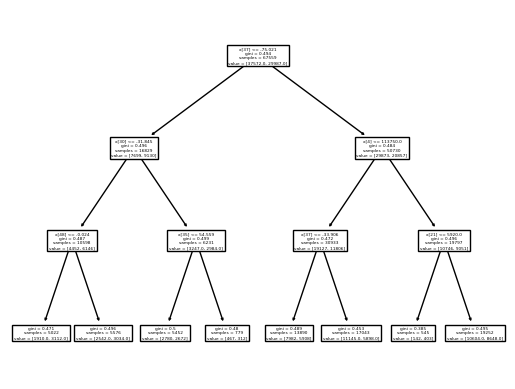

In [24]:
tree.plot_tree(tree_clf)

Model AUC: 0.548857086750382


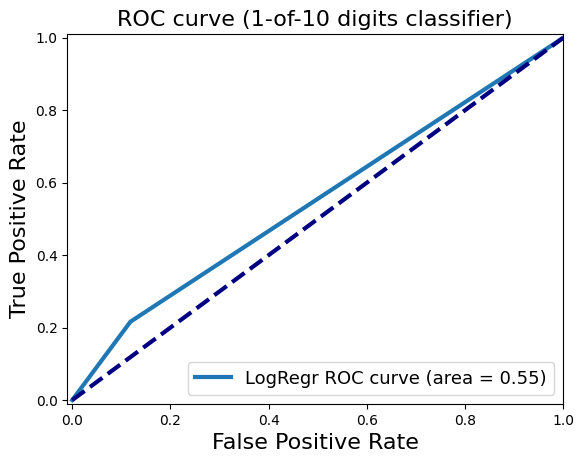

In [79]:
fpr_lr, tpr_lr, _ = roc_curve(y_test, tree_clf.predict(X_test))
roc_auc_lr = auc(fpr_lr, tpr_lr)
print("Model AUC:", roc_auc_lr)

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr, tpr_lr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve (1-of-10 digits classifier)', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.show()

In [25]:
def cross_val_scores(tree_clf, X, y, cv=5):
    scoring_metrics = ['neg_log_loss', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    
    cv_results = {'Metric': [], 'Cross-validated Scores': [], 'Mean Cross-validated Score': []}
    
    for metric in scoring_metrics:
        cv_scores = cross_val_score(tree_clf, X, y, cv=cv, scoring=metric)
        cv_results['Metric'].append(metric.capitalize())
        cv_results['Cross-validated Scores'].append(cv_scores)
        mean_score = cv_scores.mean()
        cv_results['Mean Cross-validated Score'].append('{:.3f}'.format(mean_score))
            
    df = pd.DataFrame(cv_results)
    
    return df

cv_scores_df = cross_val_scores(tree_clf, X, y)
cv_scores_df

,Metric,Cross-validated Scores,Mean Cross-validated Score
0,Neg_log_loss,"[-0.6760516936365033, -0.6726427434144906, -0....",-0.674
1,Accuracy,"[0.5782082593250444, 0.5850910301953819, 0.578...",0.583
2,Precision,"[0.5478365384615385, 0.5709239130434782, 0.551...",0.568
3,Recall,"[0.2849818682005752, 0.2627235213204952, 0.271...",0.257
4,F1,"[0.3749280250061693, 0.35985270189260943, 0.36...",0.352
5,Roc_auc,"[0.5818936892231882, 0.5873904356013933, 0.577...",0.585


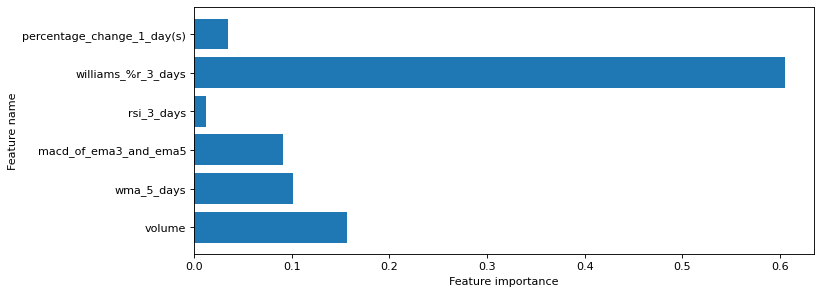

Feature importances: [0.1563827  0.10140159 0.09095135 0.01242239 0.6045857  0.03425627]


In [26]:
feature_importances = tree_clf.feature_importances_

non_zero_indices = np.nonzero(feature_importances)[0]

non_zero_importances = feature_importances[non_zero_indices]
non_zero_feature_names = X.columns[non_zero_indices]

plt.figure(figsize=(10,4), dpi=80)
plt.barh(range(len(non_zero_importances)), non_zero_importances)
plt.xlabel("Feature importance")
plt.ylabel("Feature name")
plt.yticks(np.arange(len(non_zero_importances)), non_zero_feature_names)
plt.show()

print('Feature importances: {}'.format(non_zero_importances))

# Random Forest

In [27]:
forest_clf = RandomForestClassifier(random_state=0)
forest_clf.fit(X_train, y_train)

print_model_evaluation_metrics(forest_clf, X_train, y_train, X_test, y_test)

Train Accuracy: 1.000
Test Accuracy: 0.601
Train AUC: 1.000
Test AUC: 0.579
Test Log Loss: 0.663
Classification Report:
              precision    recall  f1-score   support

       not 1       0.61      0.77      0.68     12524
           1       0.57      0.39      0.46      9996

    accuracy                           0.60     22520
   macro avg       0.59      0.58      0.57     22520
weighted avg       0.60      0.60      0.59     22520



In [86]:
# forest_clf = RandomForestClassifier(random_state=0)
# grid_values = {
#     'n_estimators': [5, 10, 15, 20, 50, 60, 75, 100],
#     'max_depth': range(10, 21, 2),
#     'max_features': range(10, 21, 2)
# }

# grid_clf_auc = GridSearchCV(forest_clf, param_grid = grid_values, scoring = 'roc_auc')
# grid_clf_auc.fit(X_train, y_train)
# y_decision_fn_scores_auc = grid_clf_auc.predict(X_test) 

# print('Test set AUC: ', roc_auc_score(y_test, y_decision_fn_scores_auc))
# print('Grid best parameter (max. AUC): ', grid_clf_auc.best_params_)
# print('Grid best score (AUC): ', grid_clf_auc.best_score_)

In [33]:
forest_clf = RandomForestClassifier(random_state=0)
grid_values = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 15, 20],
    'max_features': ['auto', 'sqrt', 'log2']
}

random_search_cv = RandomizedSearchCV(
    estimator=forest_clf,
    param_distributions=grid_values,
    n_iter=10,
    cv=5,
    scoring='roc_auc',
    random_state=42
)
random_search_cv.fit(X_train, y_train)

print(random_search_cv.best_estimator_)
print(random_search_cv.best_params_)
print(random_search_cv.best_score_)

/Users/kietnguyen/Desktop/DSLearn/vnstock_project/venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/kietnguyen/Desktop/DSLearn/vnstock_project/venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/kietnguyen/Desktop/DSLearn/vnstock_project/venv/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/Users/kietnguyen/Desktop/DSLearn/vnstock_project/venv/

RandomForestClassifier(max_depth=15, random_state=0)
{'n_estimators': 100, 'max_features': 'sqrt', 'max_depth': 15}
0.6302954878021646


In [34]:
# forest_clf = RandomForestClassifier(n_estimators=10, max_features=18, max_depth=8, random_state=0)
forest_clf = random_search_cv.best_estimator_
forest_clf.fit(X_train, y_train)

print_model_evaluation_metrics(forest_clf, X_train, y_train, X_test, y_test)

Train Accuracy: 0.883
Test Accuracy: 0.607
Train AUC: 0.871
Test AUC: 0.581
Test Log Loss: 0.659
Classification Report:
              precision    recall  f1-score   support

       not 1       0.61      0.81      0.70     12524
           1       0.60      0.35      0.44      9996

    accuracy                           0.61     22520
   macro avg       0.60      0.58      0.57     22520
weighted avg       0.60      0.61      0.58     22520



In [35]:
cv_scores_df = cross_val_scores(forest_clf, X, y)
cv_scores_df

,Metric,Cross-validated Scores,Mean Cross-validated Score
0,Neg_log_loss,"[-0.6605887729782137, -0.659792197730455, -0.6...",-0.660
1,Accuracy,"[0.6011323268206039, 0.6033525754884547, 0.607...",0.603
2,Precision,"[0.5851711825246797, 0.584441357412185, 0.5991...",0.589
3,Recall,"[0.34838064274102787, 0.36826309866199824, 0.3...",0.349
4,F1,"[0.43674557140617654, 0.45182571340902117, 0.4...",0.438
5,Roc_auc,"[0.627217015942811, 0.628037452861072, 0.63613...",0.628


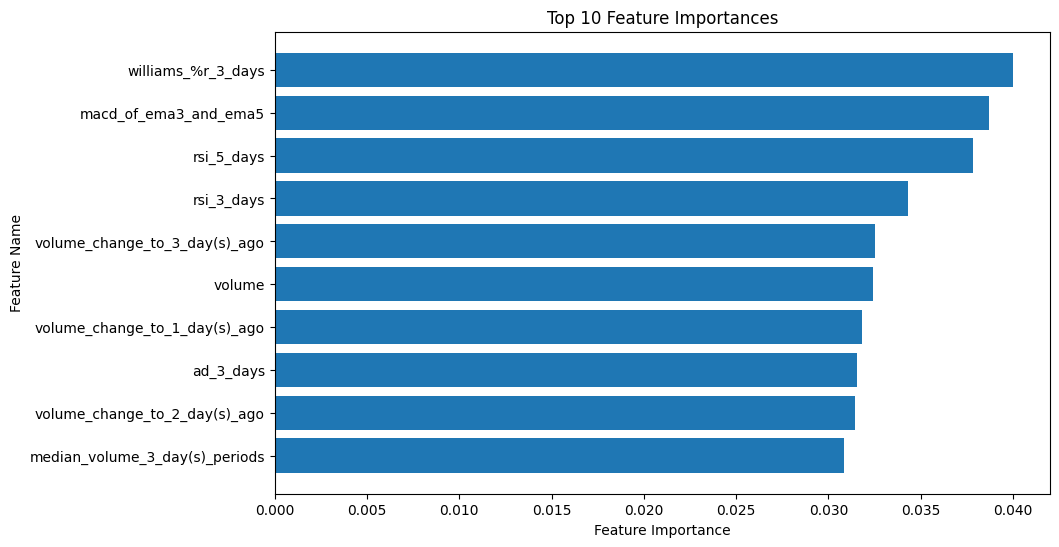

Top 10 Feature Importances:
williams_%r_3_days: 0.0399892812088225
macd_of_ema3_and_ema5: 0.03872195034539826
rsi_5_days: 0.0378123514606088
rsi_3_days: 0.03432156515136452
volume_change_to_3_day(s)_ago: 0.032494064093506664
volume: 0.032402946931929716
volume_change_to_1_day(s)_ago: 0.031790210395507015
ad_3_days: 0.031563147569279124
volume_change_to_2_day(s)_ago: 0.031443213516027455
median_volume_3_day(s)_periods: 0.030813782720374133


In [36]:
feature_importances = forest_clf.feature_importances_

non_zero_indices = np.nonzero(feature_importances)[0]

non_zero_importances = feature_importances[non_zero_indices]
non_zero_feature_names = X.columns[non_zero_indices]

sorted_indices = np.argsort(non_zero_importances)[::-1]
top_10_indices = sorted_indices[:10]

top_10_importances = non_zero_importances[top_10_indices]
top_10_feature_names = non_zero_feature_names[top_10_indices]

plt.figure(figsize=(10, 6))
plt.barh(range(len(top_10_importances)), top_10_importances, align='center')
plt.yticks(np.arange(len(top_10_importances)), top_10_feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Top 10 Feature Importances')
plt.gca().invert_yaxis()
plt.show()

print('Top 10 Feature Importances:')
for feature, importance in zip(top_10_feature_names, top_10_importances):
    print(f'{feature}: {importance}')

OOB score

n_estimators    Train Score     OOB Score


/Users/kietnguyen/Desktop/DSLearn/vnstock_project/venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


10              0.8205          0.6189


/Users/kietnguyen/Desktop/DSLearn/vnstock_project/venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


20              0.8428          0.6396
30              0.8530          0.6468
40              0.8577          0.6519
50              0.8614          0.6556
60              0.8620          0.6566
70              0.8619          0.6600
80              0.8633          0.6615
90              0.8639          0.6629
100             0.8643          0.6650
110             0.8637          0.6663
120             0.8654          0.6680
130             0.8662          0.6677
140             0.8656          0.6691
150             0.8660          0.6693
160             0.8661          0.6689
170             0.8668          0.6682
180             0.8661          0.6703
190             0.8663          0.6718
200             0.8660          0.6710


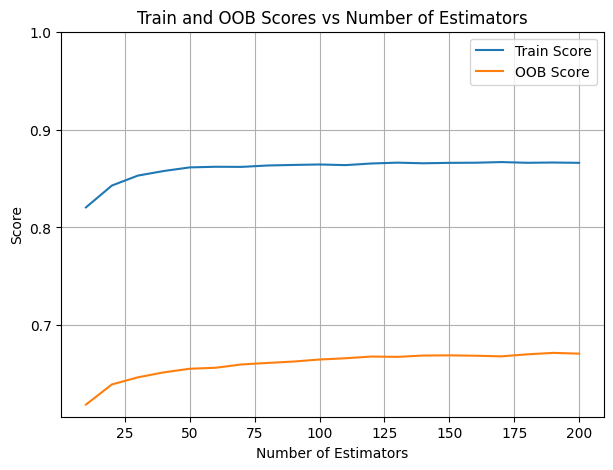

In [70]:
# forest_clf_demo = RandomForestClassifier(oob_score=True, random_state=0)
# n_estimators_range = range(10, 210, 10)

# train_scores = []
# oob_scores_val = []

# print(f"{'n_estimators':<15} {'Train Score':<15} {'OOB Score'}")
# for n_estimators in n_estimators_range:
#     forest_clf_demo.set_params(n_estimators=n_estimators, max_depth=20, min_samples_leaf=10)
#     forest_clf_demo.fit(X_train, y_train)

#     train_score = forest_clf_demo.score(X_train, y_train)
#     train_scores.append(train_score)
    
#     oob_score_val = forest_clf_demo.oob_score_
#     oob_scores_val.append(oob_score_val)

#     print(f"{n_estimators:<15} {train_score:<15.4f} {oob_score_val:.4f}")

# plt.figure(figsize=(7, 5))
# plt.plot(n_estimators_range, train_scores, label='Train Score')
# plt.plot(n_estimators_range, oob_scores_val, label='OOB Score')
# plt.xlabel('Number of Estimators')
# plt.ylabel('Score')
# plt.title('Train and OOB Scores vs Number of Estimators')
# plt.yticks(np.arange(0.7, 1, 0.1))
# plt.legend()
# plt.grid(True)
# plt.show()

## XGBoost

In [37]:
xgb_clf = XGBClassifier(objective="binary:logistic", random_state=0)
xgb_clf.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_test, y_test)])
print_model_evaluation_metrics(xgb_clf, X_train, y_train, X_test, y_test)

/Users/kietnguyen/Desktop/DSLearn/vnstock_project/venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.67712
[1]	validation_0-logloss:0.67182
[2]	validation_0-logloss:0.66806
[3]	validation_0-logloss:0.66570
[4]	validation_0-logloss:0.66448
[5]	validation_0-logloss:0.66349
[6]	validation_0-logloss:0.66221
[7]	validation_0-logloss:0.66164
[8]	validation_0-logloss:0.66105
[9]	validation_0-logloss:0.66075
[10]	validation_0-logloss:0.66048
[11]	validation_0-logloss:0.66013
[12]	validation_0-logloss:0.65963
[13]	validation_0-logloss:0.65957
[14]	validation_0-logloss:0.65911
[15]	validation_0-logloss:0.65893
[16]	validation_0-logloss:0.65893
[17]	validation_0-logloss:0.65881
[18]	validation_0-logloss:0.65882
[19]	validation_0-logloss:0.65886
[20]	validation_0-logloss:0.65884
[21]	validation_0-logloss:0.65888
[22]	validation_0-logloss:0.65877
[23]	validation_0-logloss:0.65904
[24]	validation_0-logloss:0.65925
[25]	validation_0-logloss:0.65912
[26]	validation_0-logloss:0.65937
Train Accuracy: 0.658
Test Accuracy: 0.604
Train AUC: 0.637
Test AUC: 0.582
Test Log Loss: 0

In [38]:
cv_scores_df = cross_val_scores(xgb_clf, X, y)
cv_scores_df

,Metric,Cross-validated Scores,Mean Cross-validated Score
0,Neg_log_loss,"[-0.6690962350953663, -0.6710997592444992, -0....",-0.670
1,Accuracy,"[0.5936389875666075, 0.5950821492007105, 0.603...",0.596
2,Precision,"[0.5557571758495546, 0.5553453169347209, 0.570...",0.560
3,Recall,"[0.42128298111791923, 0.44041515568338124, 0.4...",0.422
4,F1,"[0.4792659506366029, 0.49124764627937795, 0.48...",0.481
5,Roc_auc,"[0.6190415402182646, 0.6181330562590075, 0.624...",0.620


In [65]:
params = {
    "gamma": uniform(0, 0.9),
    "learning_rate": uniform(0.01, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": [20, 50, 100, 150], # default 100
}

search = RandomizedSearchCV(xgb_clf, param_distributions=params, random_state=0, n_iter=200, cv=5, scoring='roc_auc')

search.fit(X, y)

print(search.best_estimator_)
print(search.best_params_)
print(search.best_score_)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.44141292775581037, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.07822438839199697,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)
{'gamma': 0.44141292775581037, 'learning_rate': 0.07822438839199697, 'max_depth': 5, 'n_estimators': 150}
0.6324372674104092


In [104]:
# xgb_clf = search.best_estimator_
params = {
    'gamma': 0.44141292775581037, 
    'learning_rate': 0.13333333333333333, 
    'max_depth': 5, 
    'n_estimators': 150,
}

xgb_clf = XGBClassifier(**params, eval_metric='auc', booster='gbtree')

xgb_clf.fit(X_train, y_train, eval_set=[(X_test, y_test)])

[0]	validation_0-auc:0.59636
[1]	validation_0-auc:0.60268
[2]	validation_0-auc:0.60622
[3]	validation_0-auc:0.60898
[4]	validation_0-auc:0.61174
[5]	validation_0-auc:0.61420
[6]	validation_0-auc:0.61643
[7]	validation_0-auc:0.61774
[8]	validation_0-auc:0.61894
[9]	validation_0-auc:0.61911
[10]	validation_0-auc:0.62016
[11]	validation_0-auc:0.62129
[12]	validation_0-auc:0.62166
[13]	validation_0-auc:0.62195
[14]	validation_0-auc:0.62258
[15]	validation_0-auc:0.62367
[16]	validation_0-auc:0.62393
[17]	validation_0-auc:0.62460
[18]	validation_0-auc:0.62512
[19]	validation_0-auc:0.62548
[20]	validation_0-auc:0.62617
[21]	validation_0-auc:0.62629
[22]	validation_0-auc:0.62654
[23]	validation_0-auc:0.62681
[24]	validation_0-auc:0.62771
[25]	validation_0-auc:0.62801
[26]	validation_0-auc:0.62845
[27]	validation_0-auc:0.62899
[28]	validation_0-auc:0.62939
[29]	validation_0-auc:0.62983
[30]	validation_0-auc:0.62971
[31]	validation_0-auc:0.63014
[32]	validation_0-auc:0.62978
[33]	validation_0-au

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0.44141292775581037, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.13333333333333333,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [105]:
print_model_evaluation_metrics(xgb_clf, X_train, y_train, X_test, y_test)

Train Accuracy: 0.680
Test Accuracy: 0.611
Train AUC: 0.660
Test AUC: 0.589
Test Log Loss: 0.656
Classification Report:
              precision    recall  f1-score   support

       not 1       0.62      0.78      0.69     12524
           1       0.59      0.40      0.47      9996

    accuracy                           0.61     22520
   macro avg       0.61      0.59      0.58     22520
weighted avg       0.61      0.61      0.59     22520



In [106]:
cv_scores_df = cross_val_scores(xgb_clf, X, y)
cv_scores_df

,Metric,Cross-validated Scores,Mean Cross-validated Score
0,Neg_log_loss,"[-0.659334347641136, -0.659069530116427, -0.65...",-0.659
1,Accuracy,"[0.6062388987566607, 0.6041851687388987, 0.610...",0.605
2,Precision,"[0.5852691218130311, 0.575991575991576, 0.5916...",0.583
3,Recall,"[0.387520320120045, 0.41040390146304867, 0.397...",0.389
4,F1,"[0.4662955160999097, 0.4792990142387733, 0.475...",0.467
5,Roc_auc,"[0.6317248135133218, 0.6310906177100573, 0.637...",0.632


Learning Rate with Closest AUC and Log Loss: 0.13333333333333333


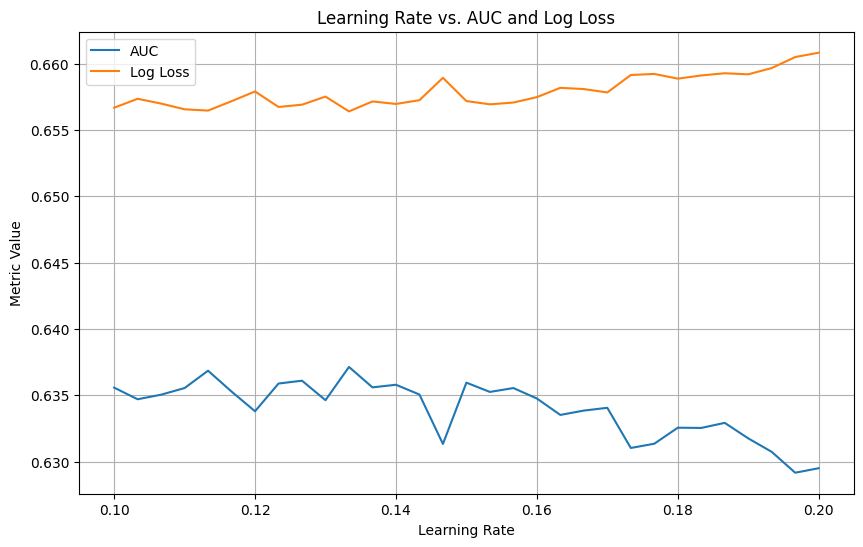

In [103]:
learning_rates = np.linspace(0.1, 0.2, 31)

base_params = {
    'gamma': 0.44141292775581037, 
    'max_depth': 5, 
    'n_estimators': 150,
    'eval_metric': 'auc'
}

best_lr = None
min_diff = float('inf')
auc_values = []
log_loss_values = []

for lr in learning_rates:
    params = base_params.copy()
    params['learning_rate'] = lr
    
    xgb_clf = XGBClassifier(**params)
    xgb_clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    
    y_pred_proba = xgb_clf.predict_proba(X_test)
    
    auc = roc_auc_score(y_test, y_pred_proba[:, 1])
    auc_values.append(auc)

    logloss = log_loss(y_test, y_pred_proba)
    log_loss_values.append(logloss)
    
    diff = abs(auc - logloss)
    
    if diff < min_diff:
        min_diff = diff
        best_lr = lr

print("Learning Rate with Closest AUC and Log Loss:", best_lr)

plt.figure(figsize=(10, 6))
plt.plot(learning_rates, auc_values, label='AUC')
plt.plot(learning_rates, log_loss_values, label='Log Loss')
plt.xlabel('Learning Rate')
plt.ylabel('Metric Value')
plt.title('Learning Rate vs. AUC and Log Loss')
plt.legend()
plt.grid(True)
plt.show()


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

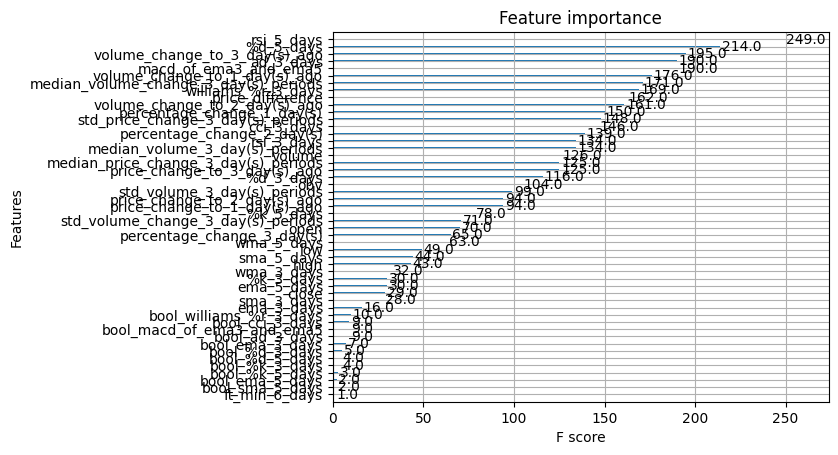

In [107]:
plot_importance(xgb_clf)

# Additional Models
## AdaBoost

In [46]:
X_no_nan_train = X_train.replace(np.nan, None)
X_no_nan_test = X_test.replace(np.nan, None)

In [50]:
ada_boost_dt_classifier = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=3, random_state=0), 
    n_estimators=5, 
    learning_rate=0.04,
    random_state=0)

ada_boost_dt_classifier.fit(X_no_nan_train, y_train)
print_model_evaluation_metrics(ada_boost_dt_classifier, X_no_nan_train, y_train, X_no_nan_test, y_test)

/Users/kietnguyen/Desktop/DSLearn/vnstock_project/venv/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Train Accuracy: 0.585
Test Accuracy: 0.586
Train AUC: 0.548
Test AUC: 0.549
Test Log Loss: 0.673
Classification Report:
              precision    recall  f1-score   support

       not 1       0.59      0.88      0.70     12524
           1       0.59      0.22      0.32      9996

    accuracy                           0.59     22520
   macro avg       0.59      0.55      0.51     22520
weighted avg       0.59      0.59      0.53     22520



In [51]:
X_no_nan = X.replace(np.nan, None)
cv_scores_df = cross_val_scores(ada_boost_dt_classifier, X_no_nan, y)
cv_scores_df

/Users/kietnguyen/Desktop/DSLearn/vnstock_project/venv/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/kietnguyen/Desktop/DSLearn/vnstock_project/venv/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/kietnguyen/Desktop/DSLearn/vnstock_project/venv/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/kietnguyen/Desktop/DSLearn/vnstock_project/venv/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarn

,Metric,Cross-validated Scores,Mean Cross-validated Score
0,Neg_log_loss,"[-0.6751290624114353, -0.6725634854412731, -0....",-0.674
1,Accuracy,"[0.582648756660746, 0.5878663410301954, 0.5790...",0.585
2,Precision,"[0.5681688533941814, 0.5787011557512383, 0.557...",0.576
3,Recall,"[0.2490934100287608, 0.26297361510566464, 0.25...",0.248
4,F1,"[0.3463444318873337, 0.36161980913077124, 0.34...",0.346
5,Roc_auc,"[0.5855686500263728, 0.5910328272992581, 0.578...",0.588


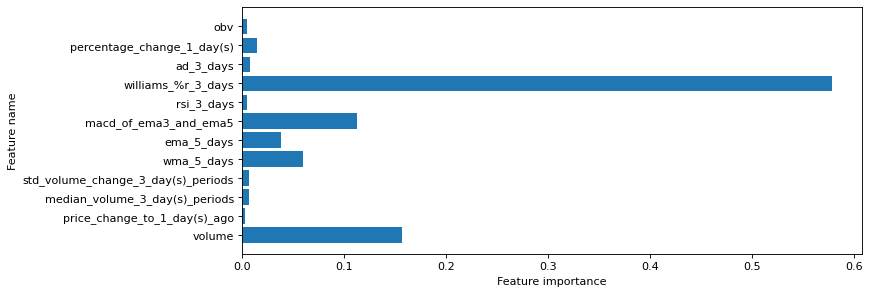

Feature importances: [0.15748466 0.00358022 0.00696866 0.00750984 0.0603914  0.03891846
 0.11282371 0.00542388 0.5787443  0.00842033 0.01471879 0.00501574]


In [55]:
feature_importances = ada_boost_dt_classifier.feature_importances_

non_zero_indices = np.nonzero(feature_importances)[0]

non_zero_importances = feature_importances[non_zero_indices]
non_zero_feature_names = X.columns[non_zero_indices]

plt.figure(figsize=(10,4), dpi=80)
plt.barh(range(len(non_zero_importances)), non_zero_importances)
plt.xlabel("Feature importance")
plt.ylabel("Feature name")
plt.yticks(np.arange(len(non_zero_importances)), non_zero_feature_names)
plt.show()

print('Feature importances: {}'.format(non_zero_importances))

## LightGBM

In [56]:
lgbm_clf = LGBMClassifier(objective='binary')
lgbm_clf.fit(X_train, y_train, eval_set=[(X_test, y_test)])
print_model_evaluation_metrics(lgbm_clf, X_train, y_train, X_test, y_test)

[LightGBM] [Info] Number of positive: 29987, number of negative: 37572
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009764 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9761
[LightGBM] [Info] Number of data points in the train set: 67559, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.443864 -> initscore=-0.225495
[LightGBM] [Info] Start training from score -0.225495
Train Accuracy: 0.663
Test Accuracy: 0.609
Train AUC: 0.641
Test AUC: 0.585
Test Log Loss: 0.657
Classification Report:
              precision    recall  f1-score   support

       not 1       0.61      0.80      0.69     12524
           1       0.60      0.37      0.46      9996

    accuracy                           0.61     22520
   macro avg       0.61      0.59      0.58     22520
weighted avg       0.61      0.61      0.59     22

In [54]:
cv_scores_df = cross_val_scores(lgbm_clf, X, y)
cv_scores_df

[LightGBM] [Info] Number of positive: 31986, number of negative: 40077
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9761
[LightGBM] [Info] Number of data points in the train set: 72063, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.443862 -> initscore=-0.225504
[LightGBM] [Info] Start training from score -0.225504
[LightGBM] [Info] Number of positive: 31986, number of negative: 40077
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010982 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9761
[LightGBM] [Info] Number of data points in the train set: 72063, number of used features: 55
[LightGBM] [Info] 

,Metric,Cross-validated Scores,Mean Cross-validated Score
0,Neg_log_loss,"[-0.6594046318541675, -0.6578765138953705, -0....",-0.659
1,Accuracy,"[0.6054063055062167, 0.6066274422735346, 0.609...",0.605
2,Precision,"[0.5896607431340872, 0.5859138972809668, 0.596...",0.589
3,Recall,"[0.36513692634738026, 0.3880205076903839, 0.37...",0.369
4,F1,"[0.45100007722604063, 0.4668622583314526, 0.46...",0.453
5,Roc_auc,"[0.6305543663612851, 0.6330883787978032, 0.638...",0.632


In [122]:
param_dist = {
    'n_estimators': range(80, 101)
}

lgbm_clf = LGBMClassifier(objective='binary', num_leaves=2, max_depth=1, learning_rate=0.018)

random_search = GridSearchCV(lgbm_clf, param_grid=param_dist, cv=5, scoring='roc_auc')

random_search.fit(X_train, y_train, eval_set=[(X_test, y_test)])

print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

[LightGBM] [Info] Number of positive: 100, number of negative: 143
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2126
[LightGBM] [Info] Number of data points in the train set: 243, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.411523 -> initscore=-0.357674
[LightGBM] [Info] Start training from score -0.357674
[LightGBM] [Info] Number of positive: 101, number of negative: 142
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2112
[LightGBM] [Info] Number of data points in the train set: 243, number of used features: 55
[LightGBM] [Info] [binary:Boos

In [57]:
lgbm_clf = LGBMClassifier(
    objective='binary',
    n_estimators=88,
    num_leaves=2,
    max_depth=1,
    learning_rate=0.018
)
lgbm_clf.fit(X_train, y_train, eval_set=[(X_test, y_test)])

[LightGBM] [Info] Number of positive: 29987, number of negative: 37572
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9761
[LightGBM] [Info] Number of data points in the train set: 67559, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.443864 -> initscore=-0.225495
[LightGBM] [Info] Start training from score -0.225495


LGBMClassifier(learning_rate=0.018, max_depth=1, n_estimators=88, num_leaves=2,
               objective='binary')

In [58]:
print_model_evaluation_metrics(lgbm_clf, X_train, y_train, X_test, y_test)

Train Accuracy: 0.579
Test Accuracy: 0.581
Train AUC: 0.538
Test AUC: 0.540
Test Log Loss: 0.678
Classification Report:
              precision    recall  f1-score   support

       not 1       0.58      0.91      0.71     12524
           1       0.60      0.17      0.27      9996

    accuracy                           0.58     22520
   macro avg       0.59      0.54      0.49     22520
weighted avg       0.59      0.58      0.51     22520



In [59]:
cv_scores_df = cross_val_scores(lgbm_clf, X, y)
cv_scores_df

[LightGBM] [Info] Number of positive: 31986, number of negative: 40077
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9761
[LightGBM] [Info] Number of data points in the train set: 72063, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.443862 -> initscore=-0.225504
[LightGBM] [Info] Start training from score -0.225504
[LightGBM] [Info] Number of positive: 31986, number of negative: 40077
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011148 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9761
[LightGBM] [Info] Number of data points in the train set: 72063, number of used features: 55
[LightGBM] [Info] 

,Metric,Cross-validated Scores,Mean Cross-validated Score
0,Neg_log_loss,"[-0.6789084274517703, -0.6790669854135297, -0....",-0.679
1,Accuracy,"[0.5763210479573713, 0.5820381882770871, 0.578...",0.580
2,Precision,"[0.5749588138385503, 0.5976578837306566, 0.585...",0.589
3,Recall,"[0.1745654620482681, 0.17869200950356384, 0.17...",0.177
4,F1,"[0.2678177458033573, 0.2751251443973816, 0.264...",0.272
5,Roc_auc,"[0.5822107184794556, 0.5787457001635619, 0.580...",0.583


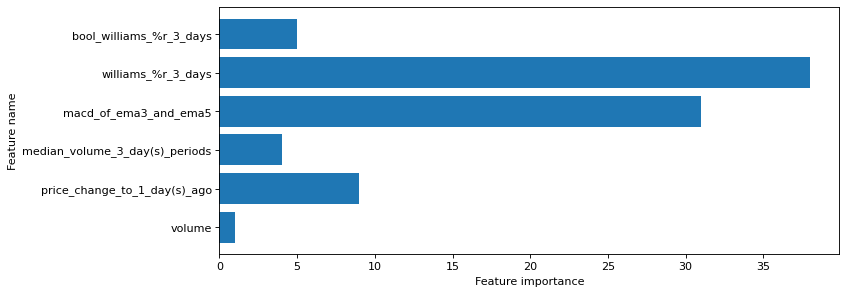

Feature importances: [ 1  9  4 31 38  5]


In [60]:
feature_importances = lgbm_clf.feature_importances_

non_zero_indices = np.nonzero(feature_importances)[0]

non_zero_importances = feature_importances[non_zero_indices]
non_zero_feature_names = X.columns[non_zero_indices]

plt.figure(figsize=(10,4), dpi=80)
plt.barh(range(len(non_zero_importances)), non_zero_importances)
plt.xlabel("Feature importance")
plt.ylabel("Feature name")
plt.yticks(np.arange(len(non_zero_importances)), non_zero_feature_names)
plt.show()

print('Feature importances: {}'.format(non_zero_importances))